# Using invariant representations to guide future exploration

I would like to further explore an idea of leveraging abstract concepts learned from previous experiences to help aid and guide the behavior of an agent when faced with a novel problem. The aim is to sequentially construct and expand agent's knowledge base, and use it to construct a behavioral policy that would guide the exploration while learning the optimal policy.

In [1]:
import os
import sys
import wandb
import gym_anytrading
import matplotlib.pyplot as plt

In [2]:
from tianshou.utils import WandbLogger
from torch.utils.tensorboard import SummaryWriter

In [3]:
if os.path.abspath(os.path.join('.')) not in sys.path:
    sys.path.append(os.path.abspath(os.path.join('.')))

In [4]:
from models import Task
from models.trainer import DQNTrainer
from models.network import TradingNetwork

In [5]:
df = gym_anytrading.datasets.STOCKS_GOOGL.copy()
window_size = 10
start_index = window_size
end_index = len(df)

In [7]:
WANDB_PROJECT = "lldqn"
WANDB_LOG_DIR = "./data"
WANDB_TENSORBOARD = "./data/tensorboard"
TASKS = [
    dict(
        env_name="Stocks-v0",
        env_model=TradingNetwork,
        env_args=dict(
            df=df,
            window_size=window_size,
            frame_bound=(start_index, end_index)
        ),
        save_data_dir="./data/models",
        use_baseline=True,
        wrappers=[
            #
        ],
    ),
]

/home/aleksa/.pyenv/versions/3.9.6/envs/lifelong_learning/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/home/aleksa/.pyenv/versions/3.9.6/envs/lifelong_learning/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/home/aleksa/.pyenv/versions/3.9.6/envs/lifelong_learning/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(
/home/aleksa/.pyenv/versions/3.9.6/envs/lifelong_learning/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:216: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of

info: {'total_reward': 446.4516270000005, 'total_profit': 0.00048215521487885777, 'position': 1}


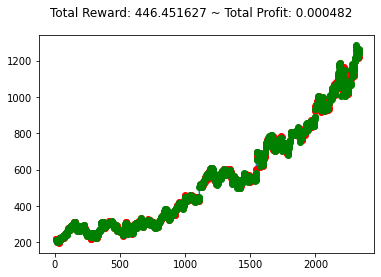

In [8]:
task = Task(**TASKS[0])
observation = task.env.reset()

while True:
    action = task.env.action_space.sample()
    observation, reward, done, info = task.env.step(action)

    if done:
        print("info:", info)
        break

plt.cla()
task.env.render_all()
plt.show()

In [ ]:
for task_data in TASKS:
    for repeat in range(1):
        task = Task(**task_data, version=repeat + 1)

        wandb.init(
            project=WANDB_PROJECT,
            dir=WANDB_LOG_DIR,
            group=task.name,
            job_type="Policy-Train",
            name=task.save_model_name,
            sync_tensorboard=True,
            reinit=True,
            monitor_gym=True,
            config={
                "train/repeat_count": 1,
            }
        )

        logger = WandbLogger()
        logger.load(SummaryWriter(WANDB_TENSORBOARD))
        trainer = DQNTrainer(task, logger=logger)
        result = trainer.run()

        print("Finished repeat {}. Time taken: {:.4}s".format(repeat + 1, result["duration"]))
